# **Required Downloads**

In [1]:
!pip install -q transformers
!pip install -q contractions
!pip install -q autocorrect

     |████████████████████████████████| 3.3 MB 13.2 MB/s 
     |████████████████████████████████| 596 kB 30.8 MB/s 
     |████████████████████████████████| 61 kB 238 kB/s 
     |████████████████████████████████| 895 kB 15.8 MB/s 
     |████████████████████████████████| 3.3 MB 42.2 MB/s 
     |████████████████████████████████| 321 kB 11.8 MB/s 
     |████████████████████████████████| 284 kB 28.2 MB/s 
     |████████████████████████████████| 622 kB 13.3 MB/s 


# **Required Imports**

In [2]:

from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import RobertaTokenizer,TFRobertaForSequenceClassification
from transformers import XLNetTokenizer, TFXLNetForSequenceClassification
from transformers import ElectraTokenizer,TFElectraForSequenceClassification
from transformers import GPT2Tokenizer,TFGPT2ForSequenceClassification
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification,TFPreTrainedModel

import time

from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd
import seaborn as sns

import tensorflow as tf
import json

import numpy as np
import pandas as pd


import os
import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

import contractions
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from autocorrect import Speller



# **Data Prepration**

## Importing Data
- The following cell is importing data from google drive and storing the files to /home/Emotiondata directory.
- Data Source: 
> https://www.kaggle.com/praveengovi/emotions-dataset-for-nlp

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DataDir = '/home/EmotionData/'
!mkdir /home/EmotionData
!unzip /content/drive/MyDrive/archive.zip 
!mv /content/*.txt /home/EmotionData

Archive:  /content/drive/MyDrive/archive.zip
  inflating: test.txt                
  inflating: train.txt               
  inflating: val.txt                 


## Loading Data
- The Following cell loads train, validation and test data to variables 
- Used Sources: 
>https://stackoverflow.com/questions/21546739/load-data-from-txt-with-pandas

In [5]:
def readDataEmotionData1(dataPath):
  data = pd.read_csv(DataDir+dataPath, sep=";", header=None, names = ['Text','Label'])
  return data;

trainData = readDataEmotionData1('train.txt')
valData = readDataEmotionData1('val.txt')
testData = readDataEmotionData1('test.txt')
# Shows how the data looks in the padas DataFrame after loading 
trainData.head()

,Text,Label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## About the Data


In [6]:
# The following function adds length coloum to pandas Dataframe
def addTextLength(dataFrame):
  lengthData = []
  for i in dataFrame['Text']:
    lengthData.append(len(i))
  dataFrame=dataFrame.assign(Length=lengthData)
  return dataFrame
trainData = addTextLength(trainData)
valData = addTextLength(valData)
testData = addTextLength(testData)
valData.head()

,Text,Label,Length
0,im feeling quite sad and sorry for myself but ...,sadness,69
1,i feel like i am still looking at a blank canv...,sadness,70
2,i feel like a faithful servant,love,30
3,i am just feeling cranky and blue,anger,33
4,i can have for a treat or if i am feeling festive,joy,49


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


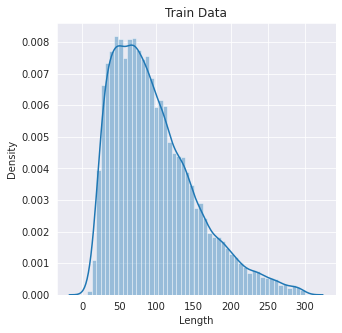

In [7]:
# This shows the distrubution of the number of characters length of the Text.
def plotDestrubrition(data,name):
  sns.set_style('darkgrid')
  plt.figure(figsize=(5,5))
  plt.title(name)
  sns.distplot(data)
plotDestrubrition(trainData['Length'],'Train Data')

In [8]:
maxSentanceLength = 300
trainData.describe()

,Length
count,16000.000000
mean,96.845812
std,55.904953
min,7.000000
25%,53.000000
50%,86.000000
75%,129.000000
max,300.000000


## Text Prepration
- Decontracted: https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/
- Spell check
- About Formatted Data
- Labels One hot enconding
- Text Enconding using Model specific, ex. BertTokenizer, RobertaTokenizer,etc.

In [9]:
def Decontracted(DataFrame):
  for i, text in enumerate(DataFrame['Text']):
    DataFrame['Text'][i] = contractions.fix(text)
  return DataFrame
trainData = Decontracted(trainData)
valData = Decontracted(valData)
testData = Decontracted(testData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# from autocorrect import Speller
# def SpellCheck(DataFrame):
#   spell = Speller(lang='en')
#   for i, text in enumerate(DataFrame['Text']):
#       DataFrame['Text'][i] = str(spell(text))
#   return DataFrame

# trainData = SpellCheck(trainData)
# valData = SpellCheck(valData)
# testData = SpellCheck(testData)

In [11]:
def LabelEncoding(DataFrame):
  labels = []
  encodeVectorizer = CountVectorizer(analyzer = "word", tokenizer = None,lowercase=True, preprocessor = None, stop_words = None)
  encodedLabels = encodeVectorizer.fit_transform(DataFrame['Label']).toarray()
  LabelsNames = list(encodeVectorizer.get_feature_names())
  for i in DataFrame['Label']:
    labels.append((list(LabelsNames).index(i)))
  return labels,LabelsNames
encodedTrainLabels,TrainLabelFeatureNames = LabelEncoding(trainData)
encodedValLabels,ValLabelFeatureNames = LabelEncoding(valData)
encodedTestLabels,TestLabelFeatureNames = LabelEncoding(testData)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
def TextEncoding(tokenizerType,
                 dataTextList, 
                 LabelList, 
                 batchSize,
                 shufflingParameter,
                 maxLen):
  tokenizer = AutoTokenizer.from_pretrained(tokenizerType)
  textEncodings = tokenizer(dataTextList,
                            truncation=True, 
                            max_length = maxLen,
                            padding="max_length")
  
  dataset = tf.data.Dataset.from_tensor_slices((
    dict(textEncodings),
    LabelList
    ))
  dataset = dataset.shuffle(shufflingParameter).batch(batchSize)
  return dataset,tokenizer

# **Model Bulding and Training**

In [162]:
def CreateModel(model,
                numLabels,
                maxSentanceLength,
                input_ids,
                mask):
  embeddings = model(input_ids,mask)[0]
  layer = tf.keras.layers.Dense(1000,activation='relu')(embeddings)
  # layer = tf.keras.layers.BatchNormalization()(layer)
  # layer = tf.keras.layers.Dropout(0.2)(layer)
  outputLayer = tf.keras.layers.Dense(6,activation='softmax',name='outputs')(layer)
  testModel = tf.keras.Model(inputs=[input_ids,mask],outputs=outputLayer)
  return testModel

In [102]:
def plotEpochs(hist,
               histKeys,
               Title,
               Ylabel,
               Xlabel = "Epochs",
               savePlotPath = ""):
  legends = []
  for i in histKeys:
    plt.plot(hist.history[i])
    legends.append(i)
  plt.title(Title)
  plt.ylabel(Ylabel)
  plt.xlabel(Xlabel)
  plt.legend(legends)
  plt.show()
  if len(savePlotPath) > 0:
    plt.savefig(savePlotPath, format="svg")


In [136]:
'''
While Trying make custom matrices, I found this post in which they have coded what I was attempting.
**Note** I changed the definition name for my own purpose
Source: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model 
'''
from keras import backend as K

def Recalls(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision_Marco(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_Macro(y_true, y_pred):
    precision = Precision_Marco(y_true, y_pred)
    recall = Recalls(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [163]:
def trainModel(
    # Default Parameters
    maxSentanceLength = 200,
    BatchSize = 16,
    shufflingParameter = 1000,
    Learning_rate=5e-5,
    Epochs=4,
    numLabels = len(encodedTrainLabels),
    ModelName = 'bert-base-uncased',
    ModelMetrics = ['accuracy'],
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    ModelTrainData = list(trainData['Text']),
    TrainLabels = encodedTrainLabels,
    ModelValData = list(valData['Text']),
    ValLabels = encodedValLabels):
  
  trainDataSet,tokenizer = TextEncoding(ModelName,
                                        ModelTrainData,
                                        TrainLabels,
                                        BatchSize,
                                        shufflingParameter,
                                        maxSentanceLength)
  valDataSet,tokenizer = TextEncoding(ModelName,
                                      ModelValData,
                                      ValLabels,
                                      BatchSize,
                                      shufflingParameter,
                                      maxSentanceLength)
  
  input_ids = tf.keras.layers.Input(shape=(maxSentanceLength,),name="input_ids", dtype='int32')
  mask = tf.keras.layers.Input(shape=(maxSentanceLength,),name="attention_mask",dtype='int32')
  tokenIds = tf.keras.layers.Input(shape=(maxSentanceLength,),name="token_ids",dtype='int32')

  modelPreTrianed = TFAutoModelForSequenceClassification.from_pretrained(ModelName,
                                                               num_labels=numLabels)
  model = CreateModel(modelPreTrianed,
                      numLabels,
                      maxSentanceLength,
                      input_ids = input_ids,
                      mask = mask)
  model.compile(optimizer=optimizer, 
                loss=loss, 
                metrics=ModelMetrics)
  StartTime = time.time()
  hist = model.fit(trainDataSet,
          epochs=Epochs,
          batch_size=BatchSize,
          validation_data =valDataSet)
  EndTime = time.time()
  TrainingTime = (EndTime-StartTime)/60
  return tokenizer,hist,model, modelPreTrianed,TrainingTime



In [96]:
def saveModelWeights(model,
                     path):
  model.save_weights(path)
  print('The Model Saved')

def savePreTrainedTransformerModel(model,
                                   path):
  model.save_pretrained(path)
  print('The PreTrained Transformer Model Saved')

  

In [161]:
# Bert Model

BertTokenizer,history,model,BertPreTrainedModel,BertTrainningTime = trainModel(ModelMetrics = ['accuracy',F1_Macro])
plotEpochs(hist = history,
           histKeys = ['accuracy','val_accuracy','F1_Macro','val_F1_Macro'],
           Title = "Bert Accuracy Graph",
           Ylabel = "Loss",
           savePlotPath = "/echos.svg" )

!mkdir /models/Bert
saveModelWeights(model,
                 '/models/Bert/BertWeights.h5')
savePreTrainedTransformerModel(BertPreTrainedModel,
                               '/models/Bert/BertPreTrainedModel')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


ResourceExhaustedError: ignored

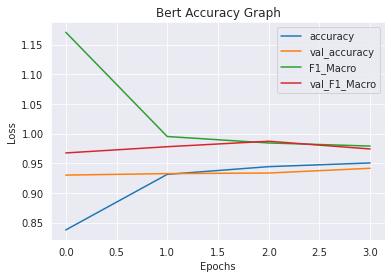

mkdir: cannot create directory ‘/models/Bert’: File exists
The Model Saved
The PreTrained Transformer Model Saved


<Figure size 432x288 with 0 Axes>

In [47]:
# # !mkdir /home/Bert
# # model.save('/test/bert',include_optimizer=False,save_format='tf')
# # model.save_weights('/home/Bert/')
# # # !gcloud auth login
# # !gsutil cp -r /home/Bert/ gs://emotion-models/
# # plotEpochs(hist, 'Bert')



INFO:tensorflow:Assets written to: /test/bert/assets


INFO:tensorflow:Assets written to: /test/bert/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
# DistilBert Model
trainDataSet,tokenizer = TextEncoding('distilbert-base-cased',list(trainData['Text']),encodedTrainLabels,BatchSize,shufflingParameter,maxSentanceLength)
valDataSet,tokenizer = TextEncoding('distilbert-base-cased',list(valData['Text']),encodedValLabels,BatchSize,shufflingParameter,maxSentanceLength)
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-cased',num_labels=6)
model = CreateModel(model,numLabels,maxSentanceLength)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy',
                       f1_m])
hist = model.fit(trainDataSet.batch(16),
          epochs=4,
          batch_size=16,
          validation_data =valDataSet.batch(16))
model.save_weights('/model/DistilBert.h5')
plotEpochs(hist, 'DistilBert')


NameError: ignored

In [ ]:
# Roberta Model
trainDataSet,tokenizer = TextEncoding('roberta-base',list(trainData['Text']),encodedTrainLabels,BatchSize,shufflingParameter,maxSentanceLength)
valDataSet,tokenizer = TextEncoding('roberta-base',list(valData['Text']),encodedValLabels,BatchSize,shufflingParameter,maxSentanceLength)
model = TFAutoModelForSequenceClassification.from_pretrained('roberta-base',num_labels=6)
model = CreateModel(model,numLabels,maxSentanceLength)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy',
                       f1_m])
hist = model.fit(trainDataSet.batch(16),
          epochs=4,
          batch_size=16,
          validation_data =valDataSet.batch(16))
model.save_weights('/model/Roberta.h5')
plotEpochs(hist, 'Roberta')

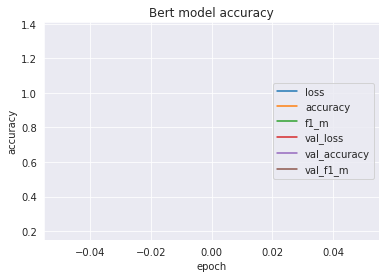

In [ ]:
# XLnet Model
trainDataSet,tokenizer = TextEncoding('xlnet-base-cased',list(trainData['Text']),encodedTrainLabels,BatchSize,shufflingParameter,maxSentanceLength)
valDataSet,tokenizer = TextEncoding('xlnet-base-cased',list(valData['Text']),encodedValLabels,BatchSize,shufflingParameter,maxSentanceLength)
model = TFAutoModelForSequenceClassification.from_pretrained('xlnet-base-cased',num_labels=6)
model = CreateModel(model,numLabels,maxSentanceLength)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy',
                       f1_m])
hist = model.fit(trainDataSet.batch(16),
          epochs=4,
          batch_size=16,
          validation_data =valDataSet.batch(16))
model.save_weights('/model/XLnet.h5')
plotEpochs(hist, 'XLnet')

In [ ]:
# Electra Model
trainDataSet,tokenizer = TextEncoding('google/electra-small-discriminator',list(trainData['Text']),encodedTrainLabels,BatchSize,shufflingParameter,maxSentanceLength)
valDataSet,tokenizer = TextEncoding('google/electra-small-discriminator',list(valData['Text']),encodedValLabels,BatchSize,shufflingParameter,maxSentanceLength)
model = TFAutoModelForSequenceClassification.from_pretrained('google/electra-small-discriminator',num_labels=6)
model = CreateModel(model,numLabels,maxSentanceLength)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy',
                       f1_m])
hist = model.fit(trainDataSet.batch(16),
          epochs=4,
          batch_size=16,
          validation_data =valDataSet.batch(16))
model.save_weights('/model/Electra.h5')
plotEpochs(hist, 'Electra')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.9M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/electra-small-discriminator were not used when initializing TFElectraForSequenceClassification: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1000/1000 [==============================] - 129s 115ms/step - loss: 0.9001 - accuracy: 0.6829 - f1_m: 1.8858 - val_loss: 0.3913 - val_accuracy: 0.8935 - val_f1_m: 1.0222
Epoch 2/4
1000/1000 [==============================] - 112s 112ms/step - loss: 0.2915 - accuracy: 0.9071 - f1_m: 1.0669 - val_loss: 0.2470 - val_accuracy: 0.9210 - val_f1_m: 0.9853
Epoch 3/4
 269/1000 [=======>......................] - ETA: 1:17 - loss: 0.2046 - accuracy: 0.9275 - f1_m: 1.0267

KeyboardInterrupt: ignored

In [ ]:
# GPT2 Model
trainDataSet,tokenizer = TextEncoding('microsoft/DialogRPT-updown',list(trainData['Text']),encodedTrainLabels,BatchSize,shufflingParameter,maxSentanceLength)
valDataSet,tokenizer = TextEncoding('microsoft/DialogRPT-updown',list(valData['Text']),encodedValLabels,BatchSize,shufflingParameter,maxSentanceLength)
model = TFAutoModelForSequenceClassification.from_pretrained('microsoft/DialogRPT-updown',num_labels=6)
model = CreateModel(model,numLabels,maxSentanceLength)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy',
                       f1_m])
hist = model.fit(trainDataSet.batch(16),
          epochs=4,
          batch_size=16,
          validation_data =valDataSet.batch(16))
model.save_weights('/model/GPT2.h5')
plotEpochs(hist, 'GPT2')

NameError: ignored

# **Model Validation**

In [146]:
class PredictEmotion:
  
  def __init__(self,
               modelName, 
               modelPath,
               modelPreTrainedPath,
               isTokenizerFast = False, 
               numLabels = 6):
    self.modelPreTrainedPath = modelPreTrainedPath
    self.modelName = modelName
    self.modelPath = modelPath
    self.isTokenizerFast = isTokenizerFast
    self.numLabels = numLabels
    self.model = self.MakeModelArchitecture()
    self.loadModelWeights()
    self.tokenizer = self.makeTokenizer()
    self.spell = Speller(lang='en')
    self.emotionTypes = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

  def MakeModelArchitecture(self):
    model = TFAutoModelForSequenceClassification.from_pretrained(self.modelName, 
                                                                 num_labels = 16000)


    input_ids = tf.keras.layers.Input(shape=(200,),name="input_ids", dtype='int32')
    mask = tf.keras.layers.Input(shape=(200,),name="attention_mask",dtype='int32')
    embeddings = model(input_ids,attention_mask=mask)[0]
    layer = tf.keras.layers.Dense(1000,activation='relu')(embeddings)
    layer = tf.keras.layers.BatchNormalization()(layer)
    outputLayer = tf.keras.layers.Dense(6,activation='softmax',name='outputs')(layer)
    ModelArchitecture = tf.keras.Model(inputs=[input_ids,mask],outputs=outputLayer)
    return ModelArchitecture

  def loadModelWeights(self):
    self.model.load_weights(self.modelPath)
  
  def makeTokenizer(self):
    return AutoTokenizer.from_pretrained(self.modelName)
  
  def TextPrepration(self,text):
    DecontractedText = contractions.fix(text)
    # SpelledText = str(self.spell(DecontractedText))
    textEncodings = self.tokenizer(DecontractedText,
                            truncation=True, 
                            max_length = 200,
                            padding="max_length", 
                            return_tensors='tf')
    return {
      'input_ids': tf.cast(textEncodings['input_ids'],tf.int32),
      'attention_mask': tf.cast(textEncodings['attention_mask'],tf.int32)}

  def PredictTextEmotion(self,text):
    prepratedText = self.TextPrepration(text)
    emotion = self.model.predict(prepratedText) 
    predictedEmotion = np.argmax(emotion)
    highestProb = emotion[0][predictedEmotion]
    return self.emotionTypes[predictedEmotion],highestProb


In [112]:
def predictEmotionTestData(predict,testDataSet):
  # startTime = time.time()
  predictedLabels = []
  for i in testDataSet:
    # print(i)
    emotion,prob = predict.PredictTextEmotion(i)
    predictedLabels.append(emotion)
  # endTime = time.time()
  # elapasedTime = (startTime-endTime)/60
  return predictedLabels


In [147]:
# !gcloud auth login
# !gsutil cp -r gs://emotion-models/Bert.h5 /home/

predictClass = PredictEmotion('bert-base-uncased',
                              '/models/Bert/BertWeights.h5',
                              '/models/Bert/BertPreTrainedModel/')
startTime = time.time()
predVal = predictEmotionTestData(predictClass,list(testData['Text']))
endTime=time.time()
from sklearn.metrics import f1_score
# f1_score(true_output, pimport matplotlib.pyplot as pltredict_output, average='macro')


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [148]:
print(predictClass.PredictTextEmotion('I love cats soo much that I would do anything for them even though it might be hard for me'))


('joy', 0.93496877)


In [149]:
print(classification_report(list(testData['Label']), predVal))
print((endTime-startTime)/60)

              precision    recall  f1-score   support

       anger       0.91      0.94      0.92       275
        fear       0.87      0.93      0.90       224
         joy       0.92      0.97      0.95       695
        love       0.89      0.73      0.80       159
     sadness       0.97      0.96      0.96       581
    surprise       0.95      0.56      0.70        66

    accuracy                           0.93      2000
   macro avg       0.92      0.85      0.87      2000
weighted avg       0.93      0.93      0.92      2000

3.123438803354899


In [ ]:

sent = 'im feeling quite sad and sorry for myself but ill snap out of it soon'

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(test.PredictTextEmotion('i feel so embarrassed'))


('sadness', 0.99991584, array([[1.1669124e-06, 7.5490807e-06, 8.7241139e-09, 2.7825772e-05,
        9.9991584e-01, 4.7542060e-05]], dtype=float32))


In [124]:
TrainLabelFeatureNames


['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']